In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

### Preprocess data

In [6]:
data = pd.read_csv('data/train.csv')

In [13]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z +_-]')
STOPWORDS = stopwords.words('english')

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    if pd.isna(text):
        return ''
    
    text = text.strip().lower()
    text = re.sub(REPLACE_BY_SPACE_RE, ' ', text)   # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = re.sub(BAD_SYMBOLS_RE, '', text)   # delete symbols which are in BAD_SYMBOLS_RE from text
    text = re.sub('-', ' ', text)  # if there is defise split the words
    text = ' '.join([s for s in text.split() if s not in STOPWORDS]) # delete stopwords from text
    text = [token for token in text.split() if not token.isdigit()]  # remove digits
    text = ' '.join([s for s in text])
    
    return text


In [15]:
num_words = data['excerpt'].apply(lambda x: len(x.split()))

In [17]:
np.mean(num_words), np.min(num_words), np.max(num_words), np.median(num_words)

(172.98200423429782, 135, 205, 175.0)

In [23]:
data['text_prepared'] = data['excerpt'].apply(text_prepare)

In [34]:
words = [s for s in data['text_prepared']]
words_un = set(' '.join(words).split())

In [44]:
len(words_un)

30674

/home/vladandronik/Documents/test_projector/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='standard_error', ylabel='Density'>

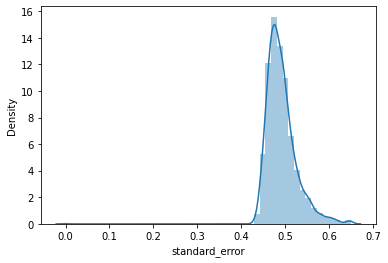

In [51]:
sns.distplot(data['standard_error'])

In [62]:
# split into different categories by how hard to identify
data['complexity'] = 0
data.loc[(data['standard_error'] >= 0.45) & (data['standard_error'] < 0.55), 'complexity'] = 1
data.loc[(data['standard_error'] >= 0.55), 'complexity'] = 2

In [64]:
data['complexity'].value_counts()

1    2513
2     182
0     139
Name: complexity, dtype: int64

### Split

In [63]:
train, val = train_test_split(data, test_size=.1, stratify=data['complexity'], random_state=17)

In [106]:
X_train = [t for t in train['text_prepared']]
X_val = [t for t in val['text_prepared']]

y_train = train['target'].values
y_val = val['target'].values

In [107]:
tfidf_vectorizer = TfidfVectorizer(min_df = 3, max_df = .9, ngram_range=(1, 2), token_pattern='\S+')

In [108]:
%%time
X_train = tfidf_vectorizer.fit_transform(X_train)
X_val = tfidf_vectorizer.transform(X_val)

CPU times: user 372 ms, sys: 0 ns, total: 372 ms
Wall time: 370 ms


In [110]:
X_train.shape, X_val.shape

((2550, 12682), (284, 12682))

### Predict

In [123]:
model = LassoCV(cv=3, random_state=17, n_jobs=3)

In [124]:
%time
model.fit(X_train, y_train)

CPU times: user 3 µs, sys: 3 µs, total: 6 µs
Wall time: 13.8 µs


RandomForestRegressor(n_jobs=3, random_state=17)

In [125]:
y_pred = model.predict(X_val)

In [126]:
from sklearn.metrics import mean_squared_error

In [127]:
np.sqrt(mean_squared_error(y_pred, y_val))

0.8692870239006549

In [121]:
# from joblib import dump, load
# dump(model, 'lasso_cv3.joblib') 

['lasso_cv3.joblib']

In [128]:
# scores:
# linear_regression: 0.8904
# lassocv: 0.8356
# randomforest: 0.8692

### Using all data

In [147]:
test = pd.read_csv('data/test.csv')

In [148]:
test['text_prepared'] = test['excerpt'].apply(text_prepare)
X_test = [s for s in test['text_prepared']]

In [149]:
X_train = [t for t in data['text_prepared']]
y_train = data['target'].values

In [150]:
%%time
tfidf_vectorizer = TfidfVectorizer(min_df = 3, max_df = .9, ngram_range=(1, 2), token_pattern='\S+')
X_train = tfidf_vectorizer.fit_transform(X_train)
X_test = tfidf_vectorizer.transform(X_test)

CPU times: user 409 ms, sys: 3.7 ms, total: 413 ms
Wall time: 412 ms


In [151]:
%%time
model = LassoCV(cv=3, random_state=17, n_jobs=3).fit(X_train, y_train)

CPU times: user 9min 24s, sys: 11min 43s, total: 21min 8s
Wall time: 2min 50s


In [154]:
y_pred = model.predict(X_test)

In [155]:
dump(model, 'lasso_cv3_alldata.joblib')

['lasso_cv3_alldata.joblib']